In [1]:
# ============================================
# STEP 1: Install Required Libraries
# ============================================
!pip install opencv-python imageio rembg matplotlib pillow numpy scikit-image onnxruntime

import cv2
import numpy as np
import matplotlib.pyplot as plt
from rembg import remove
from PIL import Image

# Helper function for displaying images
def show_img(img, title="Image"):
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(8,6))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(title)
    plt.show()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 81.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 6.4 MB/s eta 0:00:00


Upload the foreground (person) image:


Saving crc.jpg to crc.jpg
Upload the background image:


Saving background.jpg to background.jpg


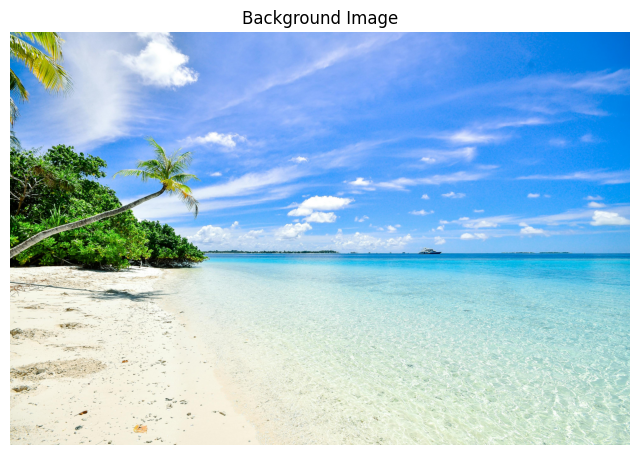

In [2]:
# ============================================
# STEP 2: UPLOAD FOREGROUND AND BACKGROUND IMAGES
# ============================================
from google.colab import files

print("Upload the foreground (person) image:")
uploaded_fg = files.upload()
fg_path = list(uploaded_fg.keys())[0]

print("Upload the background image:")
uploaded_bg = files.upload()
bg_path = list(uploaded_bg.keys())[0]

# Read background image
bg = cv2.imread(bg_path)

# Display background
show_img(bg, "Background Image")


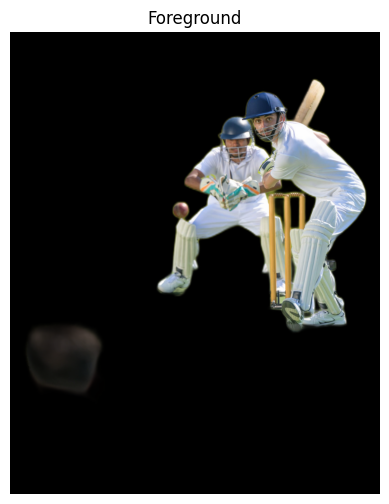

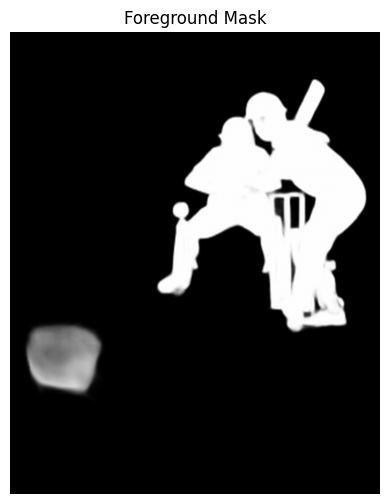

In [5]:
# ============================================
# STEP 3: Create Foreground Mask (Using rembg)
# ============================================
input_fg = Image.open(fg_path)
fg_rgba = remove(input_fg)  # Foreground with alpha
fg_rgba.save("foreground.png")

fg = cv2.imread("foreground.png", cv2.IMREAD_UNCHANGED)
b, g, r, a = cv2.split(fg)
fg_rgb = cv2.merge((b, g, r))   # Foreground (RGB only)
mask_fg = a                     # Foreground mask

show_img(fg_rgb, "Foreground")
show_img(mask_fg, "Foreground Mask")


100%|████████████████████████████████████████| 176M/176M [00:00<00:00, 201GB/s]


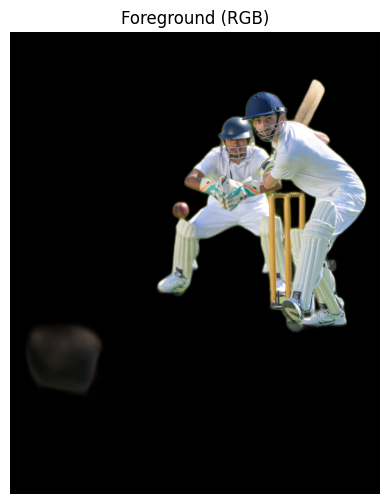

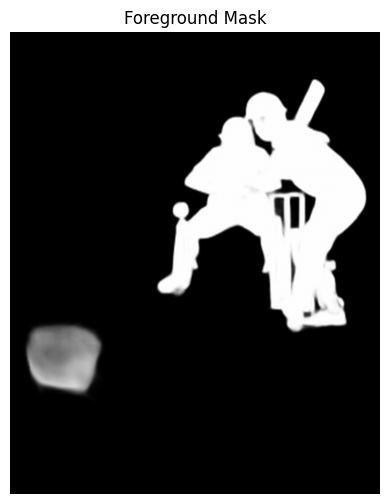

In [3]:
# ============================================
# STEP 3: REMOVE BACKGROUND FROM FOREGROUND IMAGE
# ============================================
# Use rembg (U2Net model) to segment the person and create a mask
input_image = Image.open(fg_path)
fg_rgba = remove(input_image)  # Output with transparent background
fg_rgba.save("foreground_rgba.png")

# Read the segmented image in OpenCV
fg = cv2.imread("foreground_rgba.png", cv2.IMREAD_UNCHANGED)

# Separate mask (alpha channel) from foreground
b, g, r, a = cv2.split(fg)
fg_rgb = cv2.merge((b, g, r))  # Foreground without alpha
mask = a

show_img(fg_rgb, "Foreground (RGB)")
show_img(mask, "Foreground Mask")


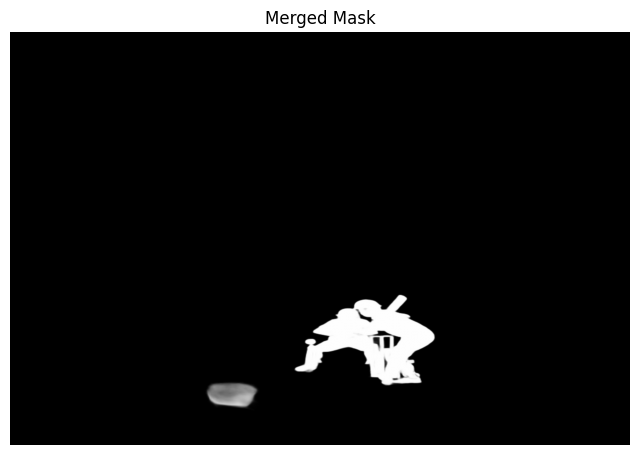

In [6]:
# ============================================
# STEP 4: Create Merged Mask
# ============================================
# Resize foreground and mask to fit background
scale = 0.4
fg_resized = cv2.resize(fg_rgb, (int(bg.shape[1] * scale), int(bg.shape[0] * scale)))
mask_resized = cv2.resize(mask_fg, (int(bg.shape[1] * scale), int(bg.shape[0] * scale)))

# Create a blank mask same as background
mask_merged = np.zeros(bg.shape[:2], dtype=np.uint8)

# Place the foreground mask onto this blank mask (bottom center)
x = (bg.shape[1] - fg_resized.shape[1]) // 2
y = bg.shape[0] - fg_resized.shape[0] - 10
mask_merged[y:y+fg_resized.shape[0], x:x+fg_resized.shape[1]] = mask_resized

show_img(mask_merged, "Merged Mask")


Estimated Light Direction: 85.49 degrees


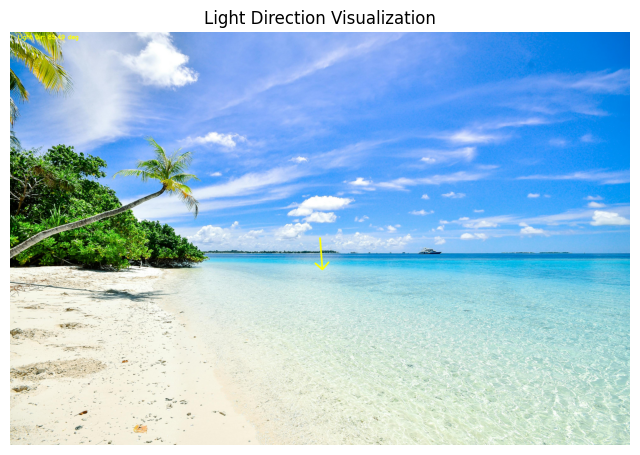

In [7]:
# ============================================
# STEP 4: LIGHT DIRECTION AND SHADOW ANALYSIS (with visualization)
# ============================================

def estimate_light_direction_with_visual(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Gradient using Sobel
    grad_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=5)
    grad_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=5)

    # Mean gradient direction
    angle = np.arctan2(np.mean(grad_y), np.mean(grad_x)) * (180 / np.pi)

    # Draw arrow to indicate light direction
    vis_img = image.copy()
    h, w = vis_img.shape[:2]
    center = (w // 2, h // 2)

    length = 200  # arrow length
    end_x = int(center[0] + length * np.cos(np.deg2rad(angle)))
    end_y = int(center[1] + length * np.sin(np.deg2rad(angle)))

    cv2.arrowedLine(vis_img, center, (end_x, end_y), (0, 255, 255), 10, tipLength=0.3)
    cv2.putText(vis_img, f"Light Dir: {angle:.2f} deg", (50, 50),
                cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 255), 3, cv2.LINE_AA)

    return angle, vis_img

light_angle, light_visual = estimate_light_direction_with_visual(bg)

print(f"Estimated Light Direction: {light_angle:.2f} degrees")

# Show the image with light direction arrow
show_img(light_visual, "Light Direction Visualization")


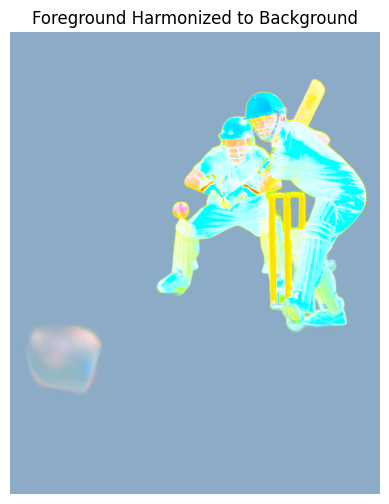

In [8]:
# ============================================
# STEP 5: COLOR HARMONIZATION (Histogram Matching)
# ============================================
# Match the color distribution of the foreground to background
def match_histogram(source, reference):
    source = cv2.cvtColor(source, cv2.COLOR_BGR2LAB)
    reference = cv2.cvtColor(reference, cv2.COLOR_BGR2LAB)
    for i in range(3):
        s_mean, s_std = cv2.meanStdDev(source[:,:,i])
        r_mean, r_std = cv2.meanStdDev(reference[:,:,i])
        source[:,:,i] = np.clip((source[:,:,i] - s_mean) * (r_std/s_std) + r_mean, 0, 255)
    return cv2.cvtColor(source, cv2.COLOR_LAB2BGR)

fg_harmonized = match_histogram(fg_rgb, bg)
show_img(fg_harmonized, "Foreground Harmonized to Background")


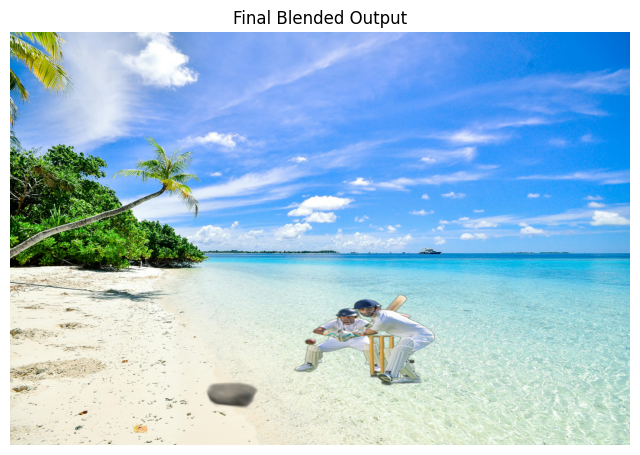

True

In [9]:
# ============================================
# STEP 5: Blending Foreground and Background
# ============================================
def blend_images(bg, fg, mask, x, y):
    result = bg.copy()
    h, w = fg.shape[:2]

    # Crop ROI
    roi = result[y:y+h, x:x+w]
    alpha = mask / 255.0

    for c in range(3):
        roi[:, :, c] = (1 - alpha) * roi[:, :, c] + alpha * fg[:, :, c]

    result[y:y+h, x:x+w] = roi
    return result

final_output = blend_images(bg, fg_resized, mask_resized, x, y)
show_img(final_output, "Final Blended Output")
cv2.imwrite("final_output.jpg", final_output)


In [10]:
def generate_shadow_and_composite(bg, fg, mask, light_angle, x, y):
    bg_copy = bg.copy()
    h, w = fg.shape[:2]

    # Ensure the person fits within background boundaries
    x_start = max(0, x)
    y_start = max(0, y)
    x_end = min(bg_copy.shape[1], x + w)
    y_end = min(bg_copy.shape[0], y + h)

    # Crop foreground and mask to match ROI size
    fg_cropped = fg[0:(y_end - y_start), 0:(x_end - x_start)]
    mask_cropped = mask[0:(y_end - y_start), 0:(x_end - x_start)]

    # Step 1: Create shadow
    shadow = cv2.merge([mask_cropped, mask_cropped, mask_cropped])
    shadow = cv2.GaussianBlur(shadow, (25, 25), 10)

    # Convert light angle to offset
    rad = np.deg2rad(light_angle)
    dx = int(40 * np.cos(rad))
    dy = int(40 * np.sin(rad))

    # Translate shadow mask
    M = np.float32([[1, 0, dx], [0, 1, dy]])
    shadow_translated = cv2.warpAffine(shadow, M, (bg_copy.shape[1], bg_copy.shape[0]))

    # Blend shadow onto background
    roi_shadow = bg_copy[y_start:y_end, x_start:x_end]
    alpha_shadow = (shadow / 255.0) * 0.5  # 50% opacity
    for c in range(3):
        roi_shadow[:, :, c] = roi_shadow[:, :, c] * (1 - alpha_shadow[:, :, c])
    bg_copy[y_start:y_end, x_start:x_end] = roi_shadow

    # Step 2: Blend person
    alpha_person = mask_cropped / 255.0
    roi_person = bg_copy[y_start:y_end, x_start:x_end]
    for c in range(3):
        roi_person[:, :, c] = (1 - alpha_person) * roi_person[:, :, c] + alpha_person * fg_cropped[:, :, c]
    bg_copy[y_start:y_end, x_start:x_end] = roi_person

    return bg_copy


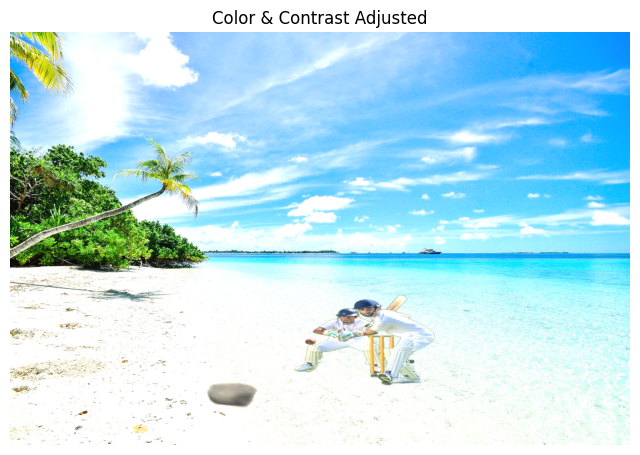

True

In [11]:
# ============================================
# STEP 6: Color and Contrast Adjustment
# ============================================
def adjust_color_contrast(image, brightness=0, contrast=0):
    """
    brightness: range -100 to 100
    contrast: range -100 to 100
    """
    beta = brightness
    alpha = 1 + (contrast / 100.0)
    adjusted = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return adjusted

final_contrast = adjust_color_contrast(final_output, brightness=10, contrast=20)
show_img(final_contrast, "Color & Contrast Adjusted")
cv2.imwrite("final_contrast.jpg", final_contrast)


In [12]:
def add_shadow(bg, mask, x, y, light_angle=45):
    shadow_bg = bg.copy()

    # Create shadow mask (soft)
    shadow = cv2.merge([mask, mask, mask])
    shadow = cv2.GaussianBlur(shadow, (35, 35), 15)

    # Offset shadow based on light direction
    rad = np.deg2rad(light_angle)
    dx = int(40 * np.cos(rad))
    dy = int(40 * np.sin(rad))

    h, w = mask.shape
    x_shadow = x + dx
    y_shadow = y + dy

    # Ensure shadow area fits inside background
    x_start = max(0, x_shadow)
    y_start = max(0, y_shadow)
    x_end = min(bg.shape[1], x_shadow + w)
    y_end = min(bg.shape[0], y_shadow + h)

    # Crop shadow mask to match ROI
    shadow_crop = shadow[0:(y_end - y_start), 0:(x_end - x_start)]

    shadow_area = shadow_bg[y_start:y_end, x_start:x_end]
    alpha_shadow = (shadow_crop / 255.0) * 0.5

    for c in range(3):
        shadow_area[:, :, c] = shadow_area[:, :, c] * (1 - alpha_shadow[:, :, c])

    shadow_bg[y_start:y_end, x_start:x_end] = shadow_area
    return shadow_bg


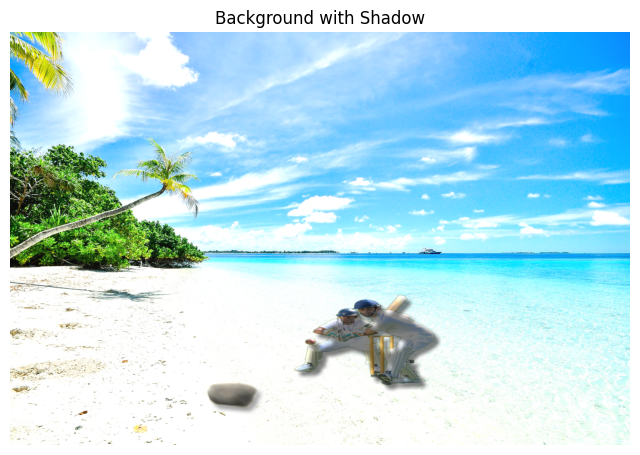

True

In [13]:
shadow_background = add_shadow(final_contrast, mask_resized, x, y, light_angle=45)
show_img(shadow_background, "Background with Shadow")
cv2.imwrite("shadow_background.jpg", shadow_background)


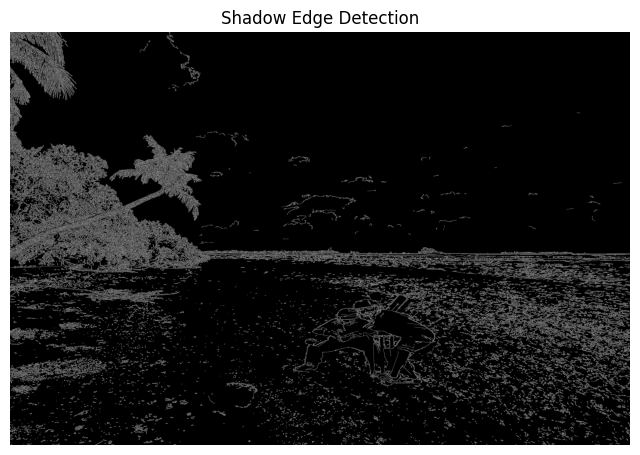

True

In [14]:
def detect_shadow_edges(shadow_bg):
    gray = cv2.cvtColor(shadow_bg, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150)
    return edges

shadow_edges = detect_shadow_edges(shadow_background)
show_img(shadow_edges, "Shadow Edge Detection")
cv2.imwrite("shadow_edges.jpg", shadow_edges)
